In [524]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline
import joblib
from sklearn.metrics import jaccard_score

<h3>1. Load the dataset and check for datatypes and data description</h3>

In [525]:
df = pd.read_csv('hypothetical_pump_failure_dataset.csv')

In [526]:
df.head()

,timestamp,vibration_level,temperature_C,pressure_PSI,flow_rate_m3h,failure
0,2024-01-01 00:00:00,0.549671,76.996777,93.248217,40.460962,0
1,2024-01-01 01:00:00,0.486174,74.623168,98.554813,45.698075,0
2,2024-01-01 02:00:00,0.564769,70.298152,92.075801,47.931972,0
3,2024-01-01 03:00:00,0.652303,66.765316,96.920385,59.438438,0
4,2024-01-01 04:00:00,0.476585,73.491117,81.063853,52.782766,0


In [527]:
df.dtypes

timestamp           object
vibration_level    float64
temperature_C      float64
pressure_PSI       float64
flow_rate_m3h      float64
failure              int64
dtype: object

In [528]:
df.describe()

,vibration_level,temperature_C,pressure_PSI,flow_rate_m3h,failure
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.501933,70.354181,100.058342,49.906404,0.049000
std,0.097922,4.987272,9.834543,5.135663,0.215976
min,0.175873,55.298057,69.804878,35.352757,0.000000
25%,0.435241,66.968792,93.520004,46.312898,0.000000
50%,0.502530,70.315386,99.997492,50.000923,0.000000
75%,0.564794,73.644411,106.609153,53.334727,0.000000
max,0.885273,85.965538,139.262377,66.215465,1.000000


Check if there are any null values

In [529]:
df.head(3)

,timestamp,vibration_level,temperature_C,pressure_PSI,flow_rate_m3h,failure
0,2024-01-01 00:00:00,0.549671,76.996777,93.248217,40.460962,0
1,2024-01-01 01:00:00,0.486174,74.623168,98.554813,45.698075,0
2,2024-01-01 02:00:00,0.564769,70.298152,92.075801,47.931972,0


There are no null values. we can proceed with further steps.

In [530]:
df.columns

Index(['timestamp', 'vibration_level', 'temperature_C', 'pressure_PSI',
       'flow_rate_m3h', 'failure'],
      dtype='object')

<h3>2. Exploratory Data Analysis (EDA)</h3>

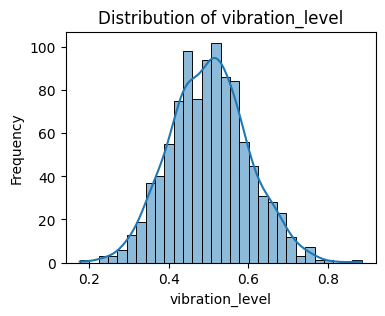

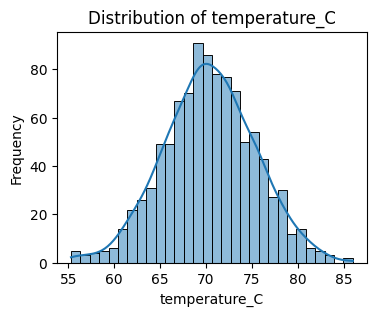

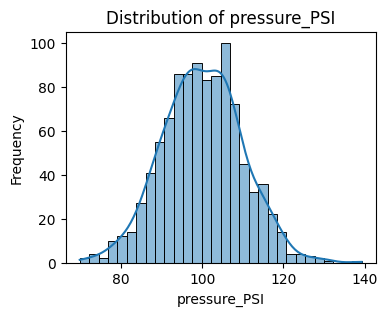

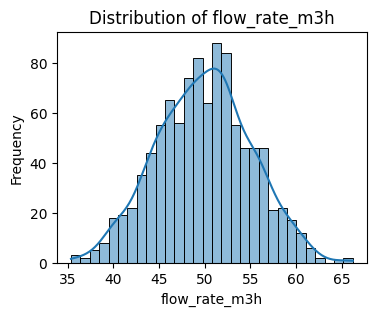

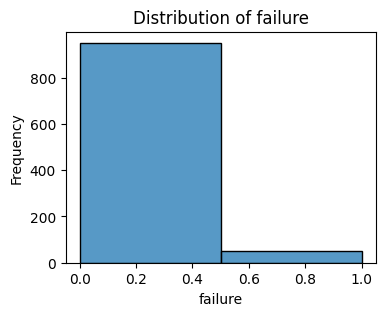

In [531]:
# List of features to visualize
features = ['vibration_level', 'temperature_C', 'pressure_PSI',
            'flow_rate_m3h', 'failure'] 

for feature in features:
    plt.figure(figsize=(4, 3))
    if feature == 'failure':
        sns.histplot(df[feature], bins=2)
    else:
        sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

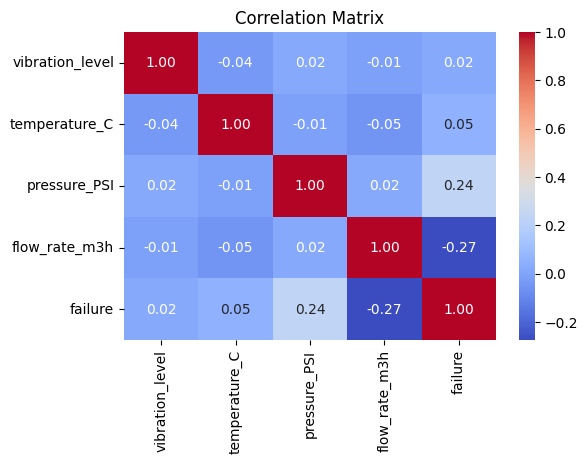

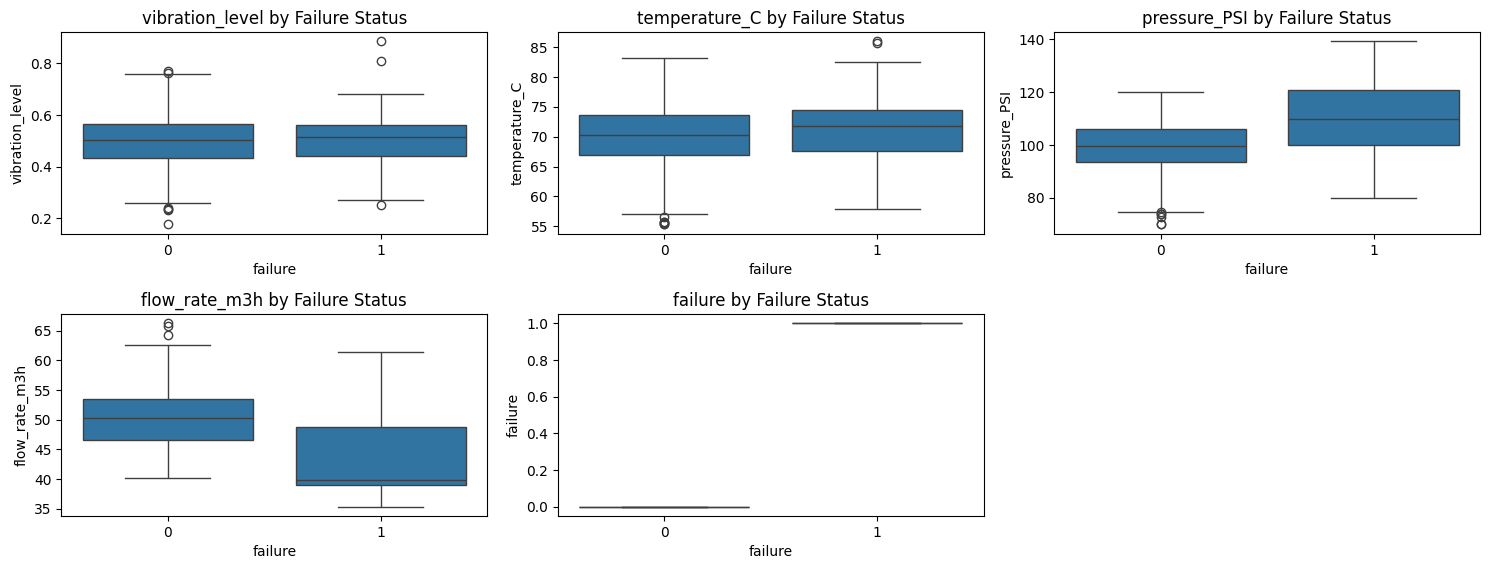

In [532]:
# Correlation matrix
plt.figure(figsize=(6, 4))
corr_matrix = df[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Box plot for features by failure status
plt.figure(figsize=(15, 11))
for i, feature in enumerate(features):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x='failure', y=feature, data=df)
    plt.title(f'{feature} by Failure Status')

plt.tight_layout()
plt.show()

<h3>3. Feature Engineering</h3>

In [533]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')

df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['week_of_month'] = (df['timestamp'].dt.day - 1) // 7 + 1

df['vibration_level_rolling_mean'] = df['vibration_level'].rolling(window=5).mean()
df['temperature_C_rolling_mean'] = df['temperature_C'].rolling(window=5).mean()
df['pressure_PSI_rolling_mean'] = df['pressure_PSI'].rolling(window=5).mean()
df['flow_rate_m3h_rolling_mean'] = df['flow_rate_m3h'].rolling(window=5).mean()

df['vibration_trend'] = df['vibration_level'] - df['vibration_level'].shift(5)
df['temp_trend'] = df['temperature_C'] - df['temperature_C'].shift(5)
df['pressure_trend'] = df['pressure_PSI'] - df['pressure_PSI'].shift(5)
df['flow_trend'] = df['flow_rate_m3h'] - df['flow_rate_m3h'].shift(5)

Taking only those rows that does not contain any null values

In [534]:
df1 = df.dropna(ignore_index=True)

In [535]:
df1.to_csv('test_data_api.csv')  # save this for batch testing the API

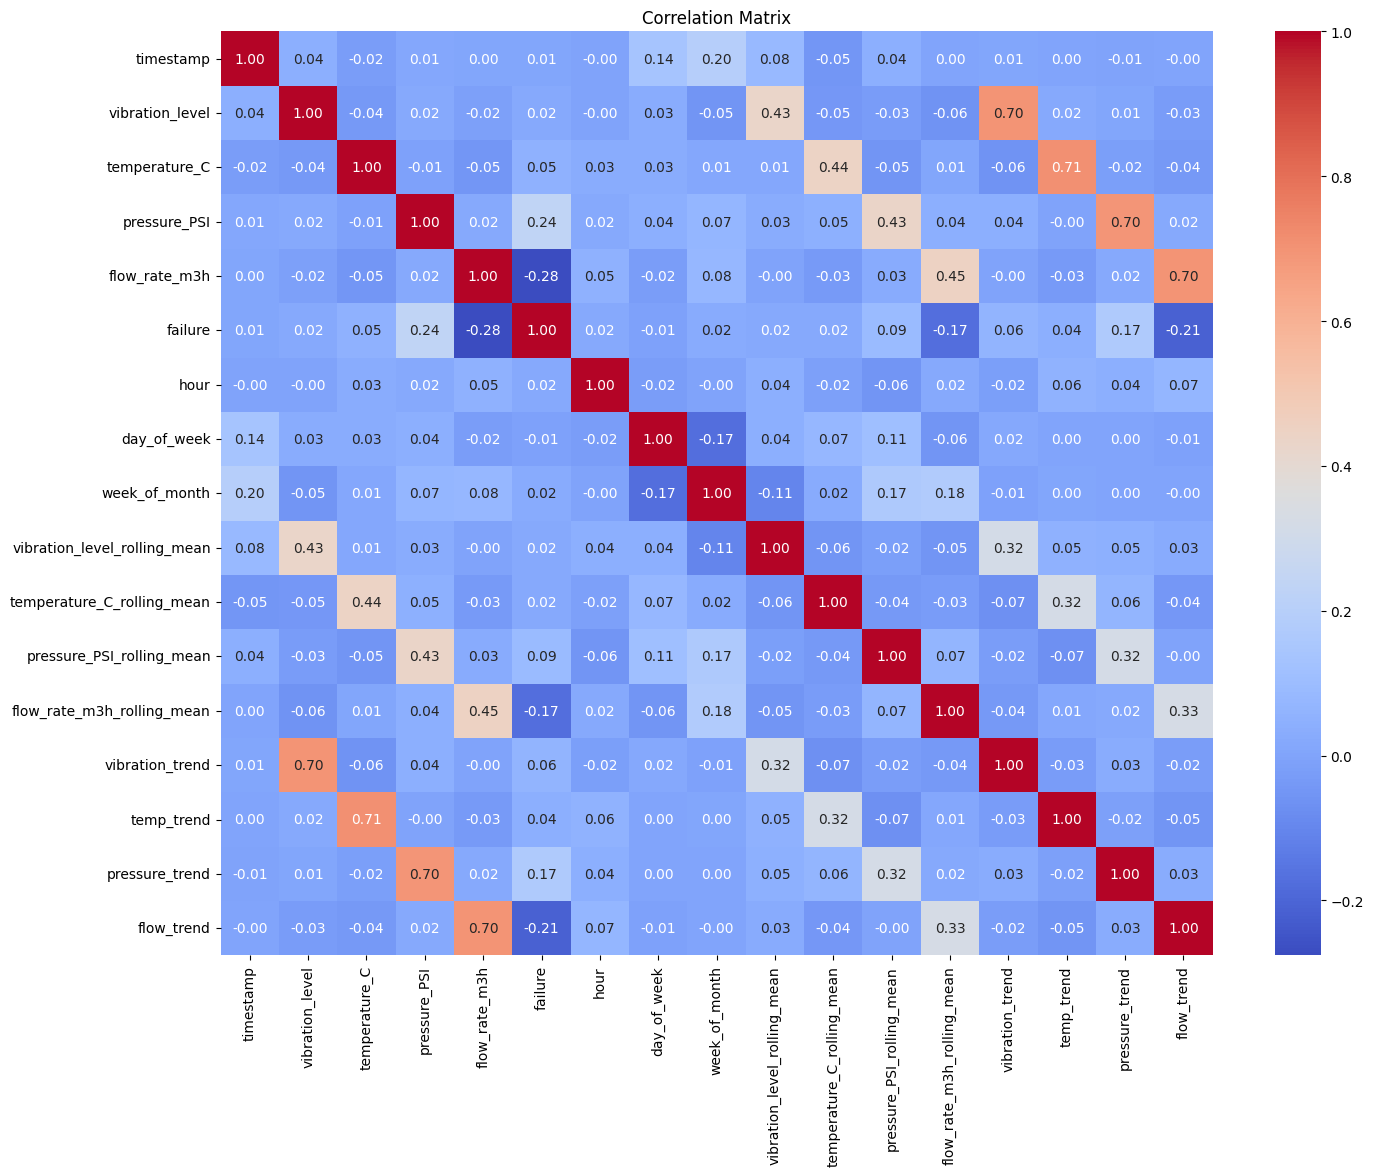

In [536]:
plt.figure(figsize=(16, 12))
corr_matrix = df1.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

<h3>4. Model build with re-sampling (SMOTE)</h3>

Splitting the dataframe into independent and dependant parameters

In [537]:
X = df1.drop(columns=['timestamp', 'failure'])
y = df1['failure']

Note: Feature scaling was considered but not implemented directly in this code to maintain feature 
interpretability.

Split into train-test

In [538]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [539]:
# Initialize SMOTE for resampling
smote = SMOTE(random_state=42)

Initialize multiple classification models and check which is the best

In [540]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss')  # Use 'logloss' for binary classification
}

# Initialize results container
results = []

# Train and evaluate models
for name, model in models.items():
    print(f"Training {name}...")

    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    model.fit(X_resampled, y_resampled)

    # Predict on the test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Evaluate the model
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Extract metrics from classification report
    metrics = {
        'Model': name,
        'ROC AUC Score': roc_auc,
        'Precision (Class 0)': report['0']['precision'],
        'Precision (Class 1)': report['1']['precision'],
        'Recall (Class 0)': report['0']['recall'],
        'Recall (Class 1)': report['1']['recall'],
        'F1 Score (Class 0)': report['0']['f1-score'],
        'F1 Score (Class 1)': report['1']['f1-score'],
        'Support (Class 0)': report['0']['support'],
        'Support (Class 1)': report['1']['support'],
        'Accuracy': report['accuracy'],
        'Macro Avg Precision': report['macro avg']['precision'],
        'Macro Avg Recall': report['macro avg']['recall'],
        'Macro Avg F1 Score': report['macro avg']['f1-score'],
        'Weighted Avg Precision': report['weighted avg']['precision'],
        'Weighted Avg Recall': report['weighted avg']['recall'],
        'Weighted Avg F1 Score': report['weighted avg']['f1-score']
    }
    
    results.append(metrics)


Training Logistic Regression...
Training K-Nearest Neighbors...
Training Decision Tree...


c:\Users\fazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Random Forest...
Training Support Vector Machine...
Training XGBoost...


In [541]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results DataFrame
print("Model Comparison:")
results_df

Model Comparison:


,Model,ROC AUC Score,Precision (Class 0),Precision (Class 1),Recall (Class 0),Recall (Class 1),F1 Score (Class 0),F1 Score (Class 1),Support (Class 0),Support (Class 1),Accuracy,Macro Avg Precision,Macro Avg Recall,Macro Avg F1 Score,Weighted Avg Precision,Weighted Avg Recall,Weighted Avg F1 Score
0,Logistic Regression,0.909023,0.979253,0.241379,0.842857,0.736842,0.905950,0.363636,280.0,19.0,0.836120,0.610316,0.789850,0.634793,0.932365,0.836120,0.871489
1,K-Nearest Neighbors,0.860432,0.976654,0.309524,0.896429,0.684211,0.934823,0.426230,280.0,19.0,0.882943,0.643089,0.790320,0.680526,0.934261,0.882943,0.902504
2,Decision Tree,0.871523,0.985240,0.535714,0.953571,0.789474,0.969147,0.638298,280.0,19.0,0.943144,0.760477,0.871523,0.803722,0.956675,0.943144,0.948123
3,Random Forest,0.991917,0.989324,0.888889,0.992857,0.842105,0.991087,0.864865,280.0,19.0,0.983278,0.939106,0.917481,0.927976,0.982942,0.983278,0.983067
4,Support Vector Machine,0.913722,0.991453,0.261538,0.828571,0.894737,0.902724,0.404762,280.0,19.0,0.832776,0.626496,0.861654,0.653743,0.945070,0.832776,0.871081
5,XGBoost,0.992669,0.992832,0.850000,0.989286,0.894737,0.991055,0.871795,280.0,19.0,0.983278,0.921416,0.942011,0.931425,0.983755,0.983278,0.983477


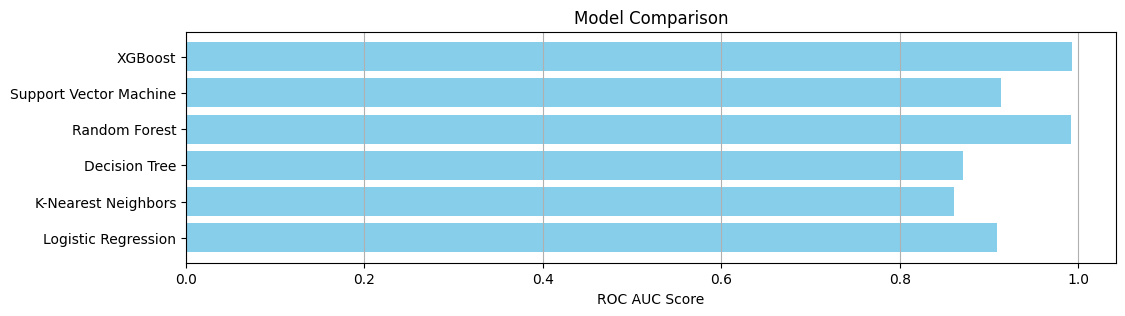

In [542]:
# Plot ROC AUC Scores
plt.figure(figsize=(12, 3))
plt.barh(results_df['Model'], results_df['ROC AUC Score'], color='skyblue')
plt.xlabel('ROC AUC Score')
plt.title('Model Comparison')
plt.grid(axis='x')
plt.show()

In [543]:
# Find the best model based on ROC AUC Score
best_model_name = results_df.loc[results_df['ROC AUC Score'].idxmax(), 'Model']
best_model_score = results_df['ROC AUC Score'].max()
print(f"Best Model: {best_model_name} \nROC AUC Score: {best_model_score:.3f}")


Best Model: XGBoost 
ROC AUC Score: 0.993


<h3>Retrieve the best model pipeline and save it</h3>

In [546]:
best_model = models[best_model_name]
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
best_model.fit(X_train, y_train)

joblib_file = f"{best_model_name.replace(' ', '_')}_model.joblib"
joblib.dump(best_model, joblib_file)
print(f"Best model saved as {joblib_file}")

Best model saved as XGBoost_model.joblib


<h3>Drilling down into the metrics of the best model - XGBoost</h3>

In [547]:
# Predict on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       280
           1       1.00      0.89      0.94        19

    accuracy                           0.99       299
   macro avg       1.00      0.95      0.97       299
weighted avg       0.99      0.99      0.99       299



<h3>Feature Importance</h3>

In [548]:
importances = best_model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
feature_importance_df

Feature Importance:


,Feature,Importance
3,flow_rate_m3h,0.406109
2,pressure_PSI,0.300663
1,temperature_C,0.053488
12,temp_trend,0.050268
11,vibration_trend,0.040062
14,flow_trend,0.032805
7,vibration_level_rolling_mean,0.028657
10,flow_rate_m3h_rolling_mean,0.024077
6,week_of_month,0.015291
4,hour,0.014670


In [549]:
# Predict on the test set
y_pred = best_model.predict(X_test)

jaccard = jaccard_score(y_test, y_pred)
print(f"Jaccard Score: {jaccard:.4f}")

Jaccard Score: 0.8947


<h3>ROC AUC Curve Analysis</h3>

In [550]:
# Predict probabilities for the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.9767


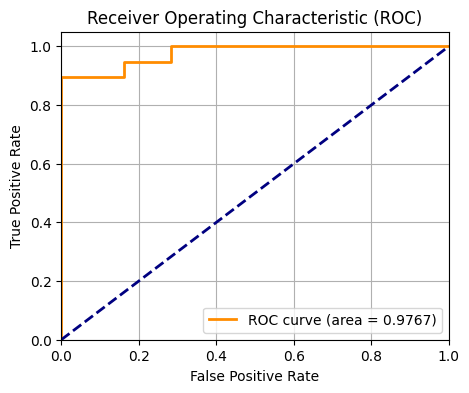

In [551]:
plt.figure(figsize=(5, 4))

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')

# Plot diagonal (no discrimination line)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)

# Show plot
plt.show()


<h3>Identifying the optimum threshold for the binary classification</h3>

In [552]:
# Predict probabilities for the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the optimal threshold
# Example: Maximize Youden's J statistic (sensitivity + specificity - 1)
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold (based on Youden's J statistic): {optimal_threshold:.4f}")

Optimal Threshold (based on Youden's J statistic): 0.7877


In [553]:
from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall curve values
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# You can choose the threshold that gives you the desired balance
# Example: Find threshold for the maximum F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold (based on F1 score): {optimal_threshold:.4f}")


Optimal Threshold (based on F1 score): 0.7877
